In [10]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
from config import RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, MOTIF_INDEXES_PATH, VARIABLES_PATTERN, K, N, P, NORMALIZE_FLAGS

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata1/variables=[0,2]
Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata1/variables=[0,2]
Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata1/variables=[0,2]


In [11]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.0703, 0.5105, 0.9451],
        [0.2359, 0.1979, 0.3327],
        [0.6146, 0.5999, 0.5013],
        [0.9397, 0.8656, 0.5207],
        [0.6865, 0.3614, 0.6493]])


In [12]:
data = np.genfromtxt(DATASET_PATH, delimiter=",").astype(int).reshape((K, N))
motif_indexes = np.genfromtxt(MOTIF_INDEXES_PATH, delimiter=",").astype(int)

print(motif_indexes)

[    0    10    22 ... 99922 99956 99992]


In [13]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, X_mask, y = create_dataset(data, lookback_period, step, forecast_period, motif_indexes, P)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([19979, 100, 3])
X_mask shape: torch.Size([19979, 100])
X_indices shape: torch.Size([19979, 6, 1])
y shape: torch.Size([19979, 1])


Number of finished trials:  100
Best trial: 76
Best hyperparameters: {'learning_rate': 0.000987141505311331, 'kernel_size': 3, 'receptive_field': 50, 'dropout': 0.028517695536759712, 'batch_size': 16, 'block_channels_0': 16, 'block_channels_1': 16, 'block_channels_2': 16, 'block_channels_3': 16, 'block_channels_4': 32}
Validation Losses: [1.623, 2.971, 1.884, 2.25, 3.289]
Mean validation loss: 2.403
Test Losses: [1.997, 4.262, 2.497, 5.127, 2.069]
Mean test loss: 3.19
Mean test MAE: 1.088 std: 0.049
Mean test RMSE: 1.752 std: 0.347


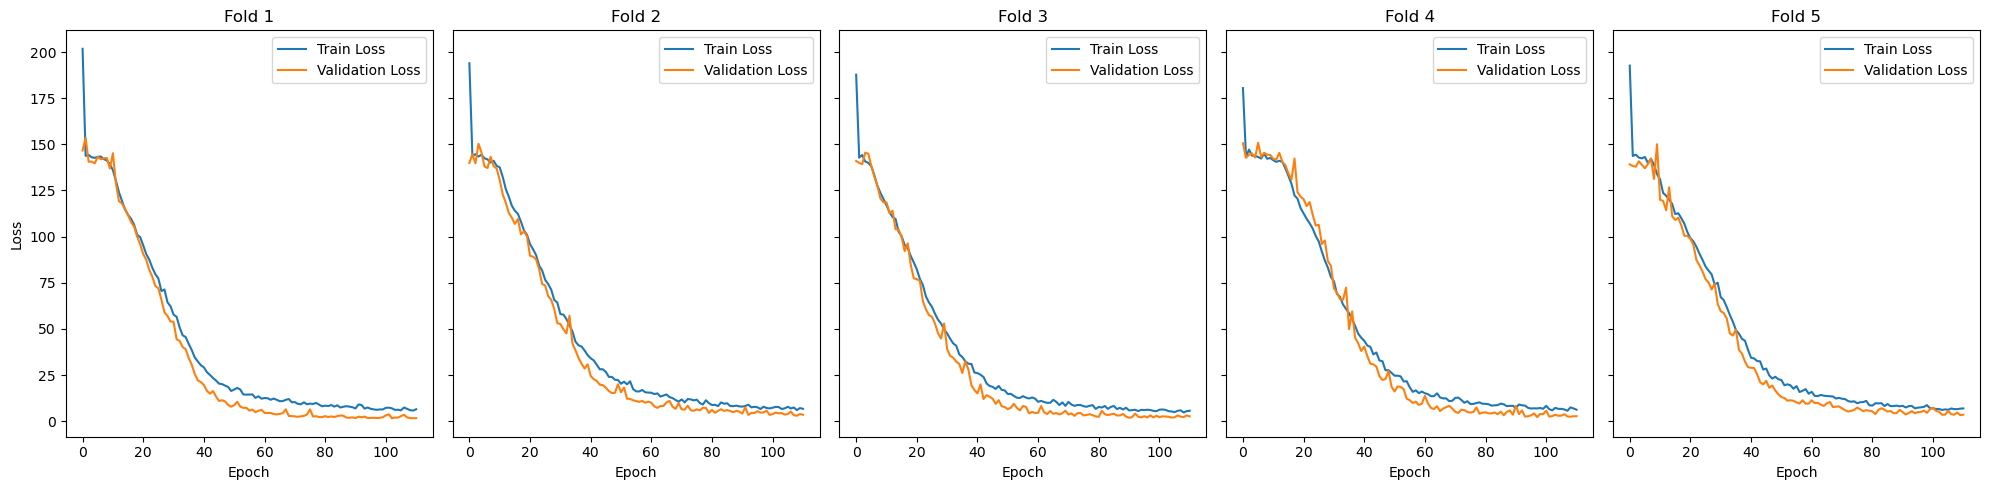

In [14]:
from models.tcn_pytorch import TCN
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "TCN"
model_name = "TCNSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "kernel_size": { # ensure receptive field is at least as large as sequence length (lookback_period)
        "type": "categorical",
        "args": [[3, 5 ,7]]
    },
    "receptive_field": {
        "type": "categorical",
        "args": [[50]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["kernel_size", "num_channels_list", "dropout"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)

X = {"X_series": X_series}
#run_optuna_study(pipeline.run_cross_val, TCN, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

Number of finished trials:  100
Best trial: 71
Best hyperparameters: {'learning_rate': 0.0006119580363897532, 'kernel_size': 7, 'receptive_field': 50, 'dropout': 7.786373649315559e-05, 'batch_size': 32, 'block_channels_0': 32, 'block_channels_1': 32, 'block_channels_2': 32, 'block_channels_3': 16}
Validation Losses: [0.536, 0.148, 0.097, 0.17, 0.162]
Mean validation loss: 0.223
Test Losses: [2.506, 0.191, 0.346, 0.221, 0.211]
Mean test loss: 0.695
Mean test MAE: 0.521 std: 0.301
Mean test RMSE: 0.708 std: 0.441


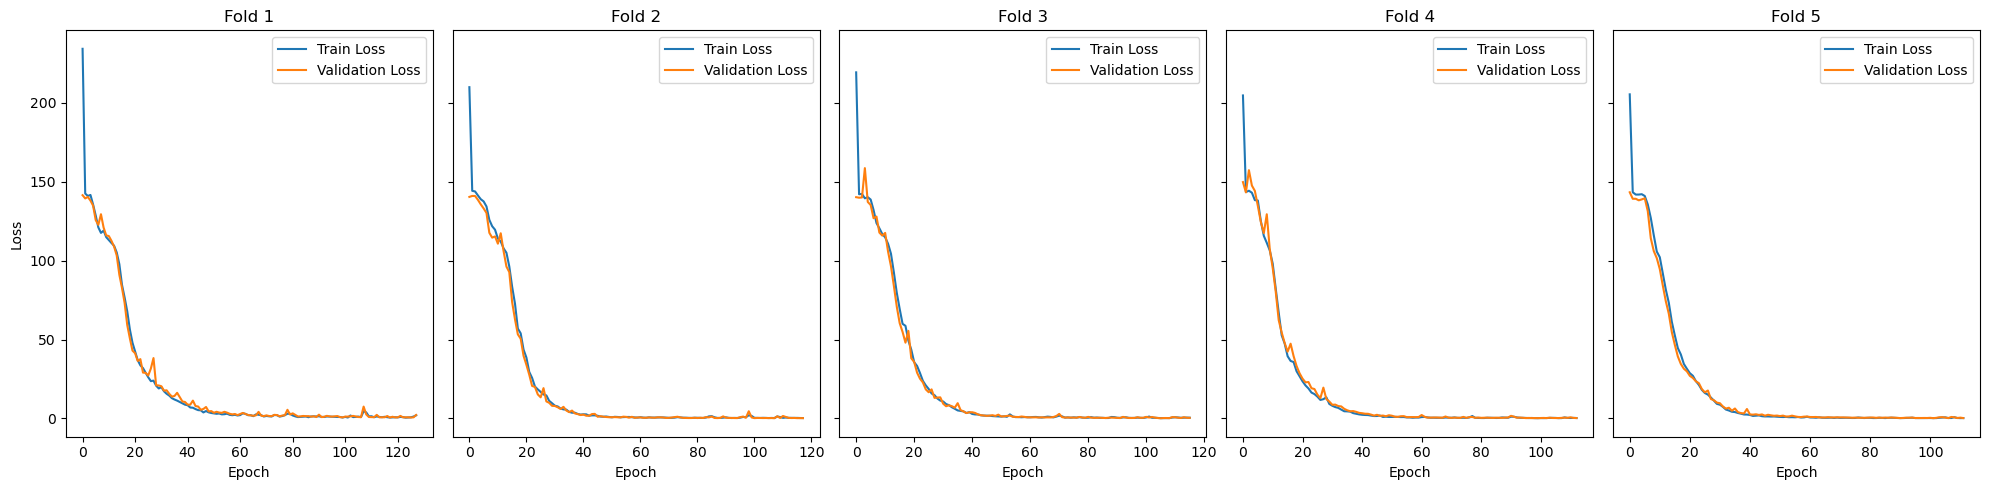

In [15]:
from models.tcn_pytorch import TCN
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "TCN"
model_name = "TCNSeries_Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "kernel_size": { # ensure receptive field is at least as large as sequence length (lookback_period)
        "type": "categorical",
        "args": [[3, 5 ,7]]
    },
    "receptive_field": {
        "type": "categorical",
        "args": [[50]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}


model_params_keys = ["kernel_size", "num_channels_list", "dropout"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)
X = {"X_series": X_series, "X_mask": X_mask}
#run_optuna_study(pipeline.run_cross_val, TCN, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

Number of finished trials:  100
Best trial: 98
Best hyperparameters: {'learning_rate': 0.0008114039807301267, 'kernel_size': 5, 'receptive_field': 10, 'dropout': 0.04125852759433878, 'batch_size': 16, 'block_channels_0': 32, 'block_channels_1': 16}
Validation Losses: [0.516, 0.546, 0.919, 0.493, 0.676]
Mean validation loss: 0.63
Test Losses: [0.726, 1.143, 1.549, 0.79, 1.861]
Mean test loss: 1.214
Mean test MAE: 0.817 std: 0.094
Mean test RMSE: 1.084 std: 0.198


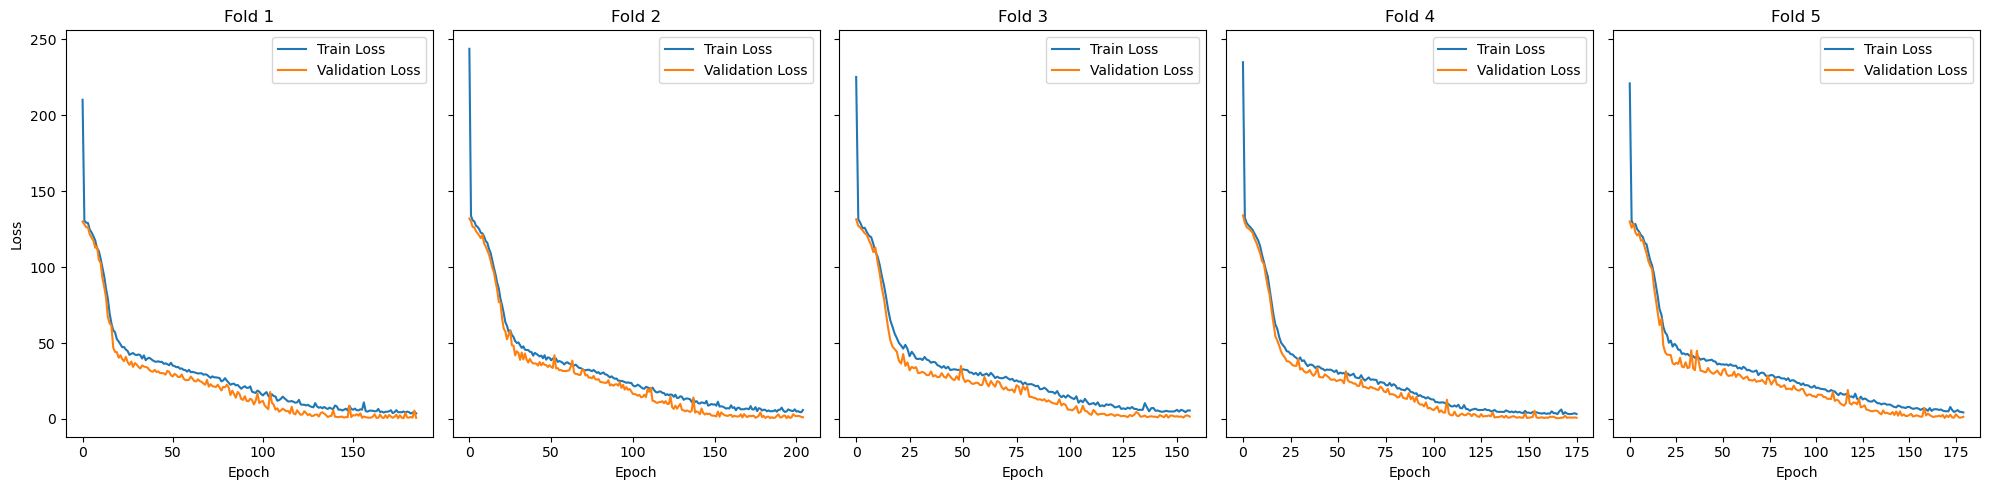

In [16]:
from models.tcn_pytorch import TCN
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "TCN"
model_name = "TCN_Indexes"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "kernel_size": { # ensure receptive field is at least as large as sequence length (lookback_period)
        "type": "categorical",
        "args": [[3, 5 ,7]]
    },
    "receptive_field": {
        "type": "categorical",
        "args": [[10]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["kernel_size", "num_channels_list", "dropout"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)
X = {"X_indices": X_indices}
#run_optuna_study(pipeline.run_cross_val, TCN, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)